In [1]:
import modelframe as mf
import models as ms
import numpy as np
import torch
import matplotlib.pyplot as plt

from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import os

import plotutilities as pu


In [2]:
def read_in_data(directory : str, conversion_dict : dict[int,int] = {0:0,1:1,2:2,3:3,4:4,5:5,6:6}):
    data = np.load(directory)
    features =  data[:,:-1]
    labels = data[:,-1]
    for original, new in conversion_dict.items():
        labels[labels == original] = new
    return torch.tensor(features).float(), torch.tensor(labels).long()



def noise_data_reduction(features, labels, data_dict = {0:True, 1:False, 2:0, 3:0, 4:0, 5:0, 6:0}, noise_to_data_ratio = 1):
    
    
    data_size = 0
    for key, val in data_dict.items():
        if val == 1:
            data_size += (labels == key).sum()
            labels[labels == key] = 0
    noise_size = int(data_size * noise_to_data_ratio)
    
    mask = torch.zeros_like(labels)
    
    for key, val in data_dict.items():
        if val  == 0:
            mask += (labels == key)
            labels[labels == key] = 1
    
    
    
    
    noise_indexes = np.where(labels == 1)
    data_indexes = np.where(labels == 0)
    print(noise_indexes)
    data_size = len(data_indexes[0])
    noise_size = len(noise_indexes[0])
    new_noise_size = int(data_size * noise_to_data_ratio)
    new_noise_indexes = np.random.permutation(noise_indexes[0])[:new_noise_size]
    data_labels = labels[data_indexes]
    noise_labels = labels[new_noise_indexes]
    data_features = features[data_indexes]  
    noise_features = features[new_noise_indexes]
    new_features = torch.cat((data_features, noise_features), dim = 0)
    new_labels = torch.cat((data_labels, noise_labels), dim = 0)
    
    
    
    # new_data = torch.cat((features[data_indexes], features[noise_indexes]), dim = 0)
    # new_labels = torch.cat((labels[data_indexes], labels[noise_mask]), dim = 0)
    
    return new_features, new_labels
    
    
    
    
    

### Binary Network
Uses a binary classification: the signal corresponds to a gravitational wave or a "glitch" which originates from other cosmic events or noise.

In [3]:
binary_model_directory = "../model/model-test-binary-001"

binary_features, binary_labels = read_in_data("../data/dataset_all_H1_bootstrap_O3a.npy", {0:0,1:1,2:1,3:1,4:1,5:1,6:1})

os.makedirs(f"{binary_model_directory}/figures", exist_ok=True)

def run_binary_network():
    

   

    binary_model = ms.GlitchClassifier(6, 32, 2)

    binary_frame = mf.GlitchModel(binary_model, binary_features, binary_labels, device = 'cuda')
    binary_frame.number_of_epochs = 100
    binary_frame.learning_rate = 0.0001
    binary_frame.setup(256)
    binary_frame.train()
    binary_frame.test_model()
    binary_frame.save_model(binary_model_directory, name = "model.pt")
    
    
    
    return binary_frame
    

In [4]:
binary_frame_1 = run_binary_network()


'1.0%'

'Epoch 100/100, Train Loss: 0.4390, Val Loss: 0.4299, Precision: 0.3301, Recall: 0.8858, Accuracy: 0.7476'

Train time: 35.03419518470764


AttributeError: 'numpy.ndarray' object has no attribute 'plot'

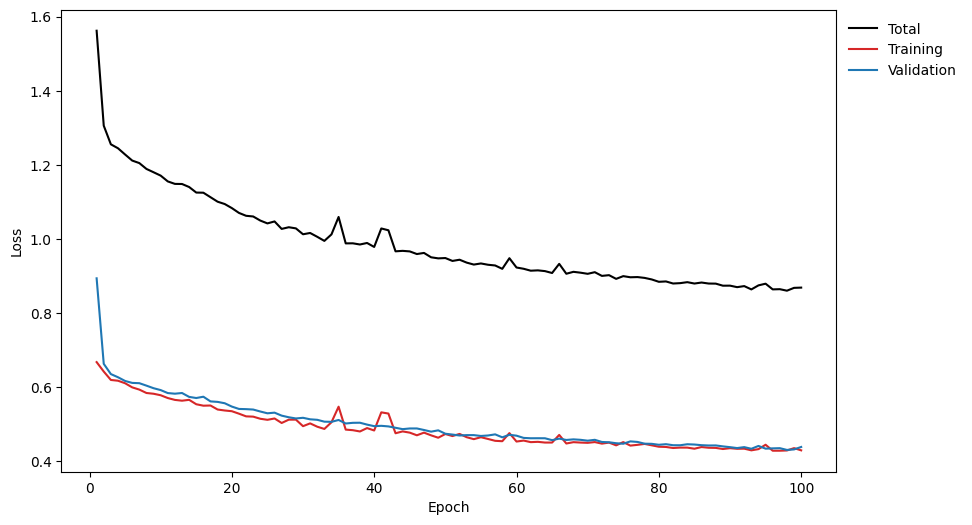

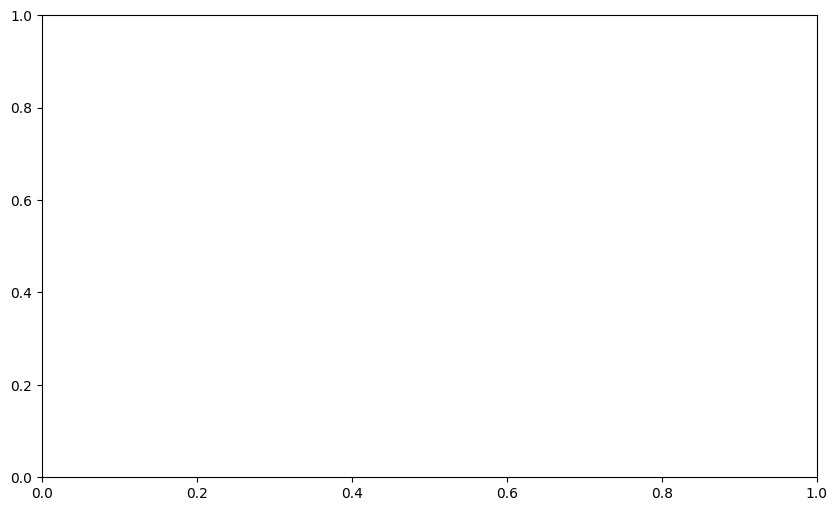

In [5]:

epochs = np.arange(1, binary_frame_1.number_of_epochs+1, 1)
pu.plot_loss(epochs, binary_frame_1.training_loss, binary_frame_1.validiation_loss)
ax = pu.plot_confusion(epochs, binary_frame_1.con_matrix_per_epoch, 0)
ax[0,0].plot(epochs, binary_frame_1.recall, color = "blue", linestyle ="dashed")


NameError: name 'binary_frame' is not defined

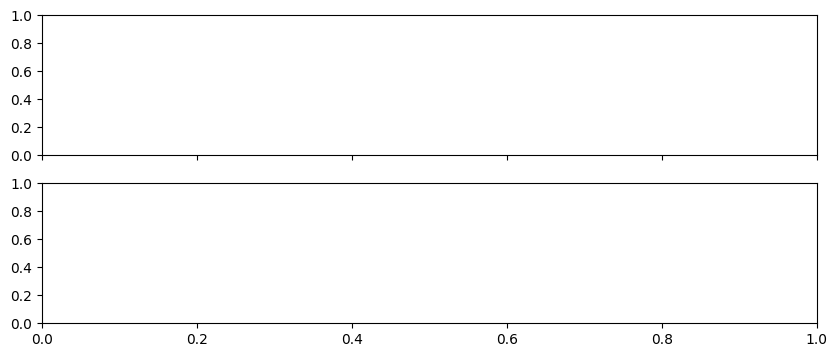

In [7]:


fig, ax = plt.subplots(2, 1, squeeze=  False, figsize = (10, 4),sharex=True)
ax[0,0].plot(epochs, binary_frame.training_loss + binary_frame.validiation_loss, label = r"Total Loss", zorder= 1, color = "k")
ax[0,0].plot(epochs, binary_frame.training_loss, label = r"Training Loss",zorder = 1, color = "tab:red")
ax[0,0].plot(epochs, binary_frame.validiation_loss, label = r"Validation Loss",zorder = 1, color = "tab:blue")
ax[1,0].plot(epochs, binary_frame.accuracy, label = r"Accuracy",zorder = 1, color = "k")
ax[1,0].plot(epochs, binary_frame.precision, label = r"Precision",zorder = 1, color = "tab:red")
ax[1,0].plot(epochs, binary_frame.recall, label = r"Recall",zorder = 1, color = "tab:blue")

ax[1,0].axhline(binary_frame.test_accuracy, label = r"Accuracy(test)", zorder = 1, color = "k", linestyle = "dashed")
ax[1,0].axhline(binary_frame.test_precision, label = r"Precision(test)", zorder = 1, color = "tab:red", linestyle = "dashed")
ax[1,0].axhline(binary_frame.test_recall, label = r"Recall(test)", zorder = 1, color = "tab:blue", linestyle = "dashed")

# ax[0,0].axhline((total_loss).mean(),zorder= 0,color = "k", linestyle = "dotted")
# ax[0,0].axhline((total_accuracy).mean(),zorder= 0,color = "k", linestyle = "dotted")
ax[0,0].set_ylabel(r"Value")
ax[1,0].set_ylabel(r"Value")
for i in range(2):
    ax[i,0].tick_params(axis="y",direction="in",which="both")
    ax[i,0].tick_params(axis="x",direction="in",which="both")
    # ax[i,0].set_yticks(np.arange(0, np.max(total_loss), int(np.max(total_loss)) /10))
    ax[i,0].set_xticks(np.arange(0, binary_frame.number_of_epochs + 1, binary_frame.number_of_epochs // 10))
    ax[i,0].xaxis.set_minor_locator(MultipleLocator(binary_frame.number_of_epochs//50))
    ax[i,0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1,0].set_xlabel(r"Epoch")
# ax[0,0].set_ylabel("Value")
ax[0,0].set_xlim(0, binary_frame.number_of_epochs)
ax[0,0].set_ylim(0, np.max(binary_frame.training_loss + binary_frame.validiation_loss))
ax[1,0].set_ylim(0, 1.2)
ax[0,0].legend(frameon=False, ncol=1, bbox_to_anchor=(1, 1), loc='upper left')
ax[1,0].legend(frameon=False, ncol=1, bbox_to_anchor=(1, 1), loc='upper left')
fig.subplots_adjust(hspace=0.1)


fig.savefig(f"{binary_model_directory}/figures/performance-overview-1.pdf", bbox_inches = "tight")

# ax[0,0].grid(True,which="minor")

### Underfitting Binary Network

In [11]:
binary_model_directory = "../model/model-test-binary-002"

binary_features, binary_labels = read_in_data("../data/dataset_all_H1_bootstrap_O3a.npy", {0:0,1:1,2:1,3:1,4:1,5:1,6:1})

binary_features, binary_labels = noise_data_reduction(binary_features, binary_labels, {0:1, 1:0, 2:0, 3:0, 4:0, 5:0, 6:0}, 1)

os.makedirs(f"{binary_model_directory}/figures", exist_ok=True)

binary_model = ms.GlitchClassifier(6, 32, 2)

binary_frame = mf.GlitchModel(binary_model, binary_features, binary_labels, device = 'cuda')
binary_frame.number_of_epochs = 750
binary_frame.learning_rate = 0.00001
binary_frame.label_weight_set = {0:1, 1:1}
binary_frame.setup(256)
binary_frame.train()
binary_frame.test_model()
binary_frame.save_model(binary_model_directory, name = "model.pt")

(array([    0,     3,     5, ..., 37797, 37798, 37799]),)
Epoch 1/750, Train Loss: 0.7961, Val Loss: 0.7346, Precision: 0.5957, Recall: 0.6980, Accuracy: 0.6028
Epoch 2/750, Train Loss: 0.7893, Val Loss: 0.7176, Precision: 0.5836, Recall: 0.7324, Accuracy: 0.5954
Epoch 3/750, Train Loss: 0.7834, Val Loss: 0.7366, Precision: 0.5822, Recall: 0.7432, Accuracy: 0.5954
Epoch 4/750, Train Loss: 0.7785, Val Loss: 0.7299, Precision: 0.5893, Recall: 0.7396, Accuracy: 0.6028
Epoch 5/750, Train Loss: 0.7736, Val Loss: 0.7136, Precision: 0.5892, Recall: 0.7468, Accuracy: 0.6037
Epoch 6/750, Train Loss: 0.7688, Val Loss: 0.7211, Precision: 0.5907, Recall: 0.7541, Accuracy: 0.6065
Epoch 7/750, Train Loss: 0.7640, Val Loss: 0.7189, Precision: 0.5861, Recall: 0.7631, Accuracy: 0.6028
Epoch 8/750, Train Loss: 0.7590, Val Loss: 0.8026, Precision: 0.5932, Recall: 0.7595, Accuracy: 0.6102
Epoch 9/750, Train Loss: 0.7548, Val Loss: 0.7260, Precision: 0.5903, Recall: 0.7685, Accuracy: 0.6083
Epoch 10/750, T

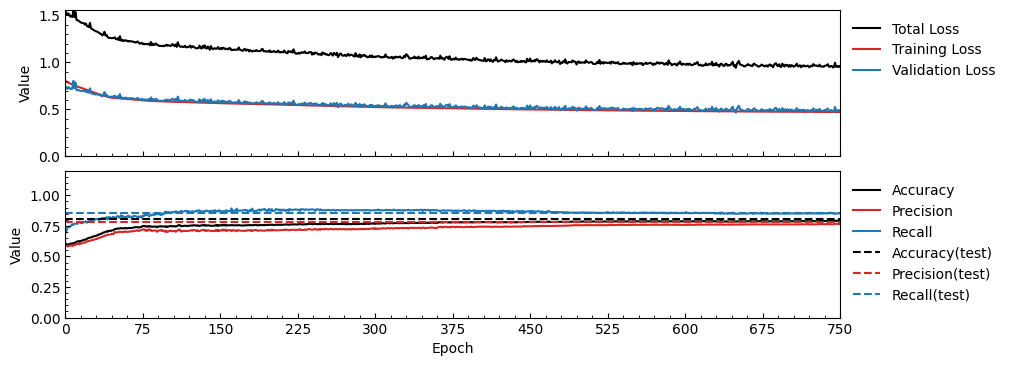

In [12]:

epochs = np.arange(1, binary_frame.number_of_epochs+1, 1)


fig, ax = plt.subplots(2, 1, squeeze=  False, figsize = (10, 4),sharex=True)
ax[0,0].plot(epochs, binary_frame.training_loss + binary_frame.validiation_loss, label = r"Total Loss", zorder= 1, color = "k")
ax[0,0].plot(epochs, binary_frame.training_loss, label = r"Training Loss",zorder = 1, color = "tab:red")
ax[0,0].plot(epochs, binary_frame.validiation_loss, label = r"Validation Loss",zorder = 1, color = "tab:blue")
ax[1,0].plot(epochs, binary_frame.accuracy, label = r"Accuracy",zorder = 1, color = "k")
ax[1,0].plot(epochs, binary_frame.precision, label = r"Precision",zorder = 1, color = "tab:red")
ax[1,0].plot(epochs, binary_frame.recall, label = r"Recall",zorder = 1, color = "tab:blue")

ax[1,0].axhline(binary_frame.test_accuracy, label = r"Accuracy(test)", zorder = 1, color = "k", linestyle = "dashed")
ax[1,0].axhline(binary_frame.test_precision, label = r"Precision(test)", zorder = 1, color = "tab:red", linestyle = "dashed")
ax[1,0].axhline(binary_frame.test_recall, label = r"Recall(test)", zorder = 1, color = "tab:blue", linestyle = "dashed")

# ax[0,0].axhline((total_loss).mean(),zorder= 0,color = "k", linestyle = "dotted")
# ax[0,0].axhline((total_accuracy).mean(),zorder= 0,color = "k", linestyle = "dotted")
ax[0,0].set_ylabel(r"Value")
ax[1,0].set_ylabel(r"Value")
for i in range(2):
    ax[i,0].tick_params(axis="y",direction="in",which="both")
    ax[i,0].tick_params(axis="x",direction="in",which="both")
    # ax[i,0].set_yticks(np.arange(0, np.max(total_loss), int(np.max(total_loss)) /10))
    ax[i,0].set_xticks(np.arange(0, binary_frame.number_of_epochs + 1, binary_frame.number_of_epochs // 10))
    ax[i,0].xaxis.set_minor_locator(MultipleLocator(binary_frame.number_of_epochs//50))
    ax[i,0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1,0].set_xlabel(r"Epoch")
# ax[0,0].set_ylabel("Value")
ax[0,0].set_xlim(0, binary_frame.number_of_epochs)
ax[0,0].set_ylim(0, np.max(binary_frame.training_loss + binary_frame.validiation_loss))
ax[1,0].set_ylim(0, 1.2)
ax[0,0].legend(frameon=False, ncol=1, bbox_to_anchor=(1, 1), loc='upper left')
ax[1,0].legend(frameon=False, ncol=1, bbox_to_anchor=(1, 1), loc='upper left')
fig.subplots_adjust(hspace=0.1)


fig.savefig(f"{binary_model_directory}/figures/performance-overview-1.pdf", bbox_inches = "tight")

# ax[0,0].grid(True,which="minor")

### Multiclass Network

In [25]:
multi_model_directory = "../model/model-test-multi-003"

multi_features, multi_labels = read_in_data("../data/dataset_all_H1_bootstrap_O3a.npy", {0:0,1:1,2:2,3:3,4:4,5:5,6:6})

os.makedirs(f"{multi_model_directory}/figures", exist_ok=True)

multi_model = ms.GlitchClassifier_MultiClass_Optimized(6, 32, 7)

multi_frame = mf.GlitchModel(multi_model, multi_features, multi_labels,{0:1, 1:1, 2:1, 3:1, 4:1, 5:1, 6:1}, device = 'cuda')
multi_frame.number_of_epochs = 750
multi_frame.learning_rate = 0.00001
# multi_frame.label_weight_set = 

multi_frame.setup(256*2)
multi_frame.train()
multi_frame.test_model()
multi_frame.save_model(multi_model_directory, name = "model.pt")

Epoch 1/750, Train Loss: 5.4495, Val Loss: 5.3943, Precision: 0.4830, Recall: 1.0000, Accuracy: 0.1389
Epoch 2/750, Train Loss: 5.0964, Val Loss: 5.2536, Precision: 0.4830, Recall: 1.0000, Accuracy: 0.1389
Epoch 3/750, Train Loss: 4.8743, Val Loss: 5.0187, Precision: 0.4830, Recall: 1.0000, Accuracy: 0.1389
Epoch 4/750, Train Loss: 4.6178, Val Loss: 4.7431, Precision: 0.4825, Recall: 1.0000, Accuracy: 0.1389
Epoch 5/750, Train Loss: 4.3954, Val Loss: 4.6263, Precision: 0.4825, Recall: 1.0000, Accuracy: 0.1389
Epoch 6/750, Train Loss: 4.1666, Val Loss: 4.2532, Precision: 0.4825, Recall: 1.0000, Accuracy: 0.1389
Epoch 7/750, Train Loss: 3.9985, Val Loss: 4.1605, Precision: 0.4821, Recall: 1.0000, Accuracy: 0.1389
Epoch 8/750, Train Loss: 3.8166, Val Loss: 3.8829, Precision: 0.4793, Recall: 1.0000, Accuracy: 0.1376
Epoch 9/750, Train Loss: 3.5511, Val Loss: 3.6728, Precision: 0.4740, Recall: 1.0000, Accuracy: 0.1349
Epoch 10/750, Train Loss: 3.3551, Val Loss: 3.4918, Precision: 0.4729, Re

In [26]:
multi_frame.con_matrix.confusion_matrix

array([[373.,   9.,   2.,  19.,  33.,  51.,  76.],
       [109., 215.,  10.,   0.,   7., 192.,  10.],
       [  3.,   5., 467.,   0.,  34.,   2.,   9.],
       [231.,   1.,   0., 145.,  19.,  55.,  66.],
       [ 20.,   0.,  20.,  15., 300.,   0., 182.],
       [ 80.,  12.,   1.,   3.,   4., 464.,   5.],
       [ 30.,   2.,  64.,  79.,  89.,   0., 267.]])

/tmp/ipykernel_25263/1313096599.py:44: RuntimeWarning: invalid value encountered in scalar divide
  class_precision[c] = mat.confusion_matrix[c,c] / (mat.confusion_matrix[:,c].sum())


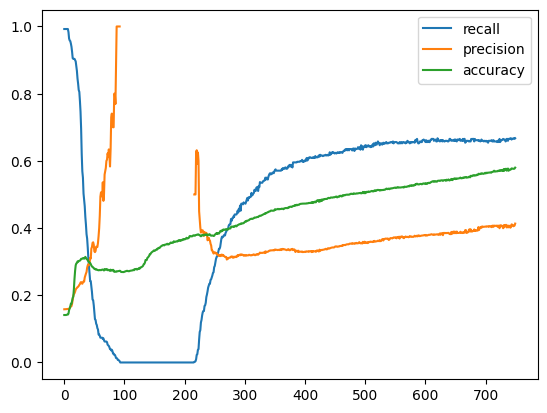

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn  as sk

def plot_confusion_matrix_correlation(confusion_matrix):
    """
    Plots a correlation heatmap for the accuracy of an n x n confusion matrix.
    
    Parameters:
    confusion_matrix (np.ndarray): The confusion matrix (n x n).
    """
    # Calculate the accuracy for each class
    
    confusion_matrix = confusion_matrix / np.sum(confusion_matrix, axis=1)
    
    mat = sk.metrics.ConfusionMatrixDisplay(confusion_matrix=confusion_matrix)
    mat.plot()
    # print(confusion_matrix[:,0].sum())
    
    # accuracy = np.diag(confusion_matrix) / confusion_matrix.sum(axis=1)
    
    # # Create a correlation matrix
    # correlation_matrix = np.outer(accuracy, accuracy)
    
    # # Plot the correlation matrix
    # plt.figure(figsize=(10, 8))
    # sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=range(confusion_matrix.shape[0]), yticklabels=range(confusion_matrix.shape[0]))
    # plt.title("Correlation Plot for Accuracy of Confusion Matrix")
    # plt.xlabel("Class")
    # plt.ylabel("Class")
    # plt.show()
recall = []
precision = []
accuracy = []

class_recall = np.zeros((7))
class_precision = np.zeros((7))
class_accuracy = np.zeros((7))

for mat in multi_frame.con_matrix_per_epoch:
    for c in range(7):
        class_recall[c] = mat.confusion_matrix[c,c] / (mat.confusion_matrix[c].sum())
        class_precision[c] = mat.confusion_matrix[c,c] / (mat.confusion_matrix[:,c].sum())
        class_accuracy[c] = mat.confusion_matrix[c,c] / (mat.confusion_matrix.sum())
    
    recall.append(class_recall.copy())
    precision.append(class_precision.copy())
    accuracy.append(class_accuracy.copy())
    
#     recall.append(np.diag(mat.confusion_matrix)/mat.confusion_matrix.sum())
# recall = np.array(recall)
# Example usage
# confusion_matrix = np.array([[50, 2, 1], [10, 40, 5], [3, 4, 60]])
# plot_confusion_matrix_correlation(confusion_mix
# plot_confusion_matrix_correlation(multi_frame.con_matrix_per_epoch[0].confusion_matrix)
# plot_confusion_matrix_correlation(multi_frame.con_matrix_per_epoch[10].confusion_matrix)
# plot_confusion_matrix_correlation(multi_frame.con_matrix_per_epoch[20].confusion_matrix)
# plot_confusion_matrix_correlation(multi_frame.con_matrix_per_epoch[30].confusion_matrix)
# plot_confusion_matrix_correlation(multi_frame.con_matrix_per_epoch[40].confusion_matrix)
# plot_confusion_matrix_correlation(multi_frame.con_matrix_per_epoch[100].confusion_matrix)
# plot_confusion_matrix_correlation(multi_frame.con_matrix_per_epoch[200].confusion_matrix)
# plot_confusion_matrix_correlation(multi_frame.con_matrix_per_epoch[249].confusion_matrix)


plt.plot(np.array(recall)[:,0],label = "recall")
plt.plot(np.array(precision)[:,0],label = "precision")
# plt.plot(accuracy)
plt.plot(np.array(accuracy).sum(axis = 1),label = "accuracy")
plt.legend()
# # plt.plot(recall.sum(axis = 1))

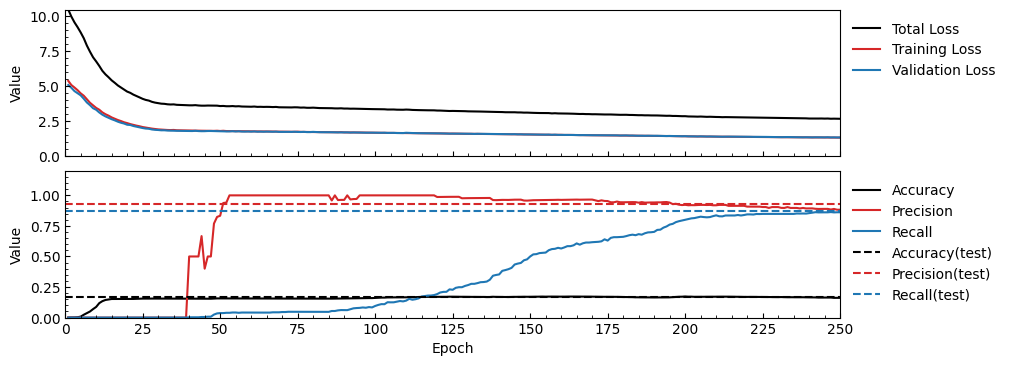

In [6]:

epochs = np.arange(1, multi_frame.number_of_epochs+1, 1)


fig, ax = plt.subplots(2, 1, squeeze=  False, figsize = (10, 4),sharex=True)
ax[0,0].plot(epochs, multi_frame.training_loss + multi_frame.validiation_loss, label = r"Total Loss", zorder= 1, color = "k")
ax[0,0].plot(epochs, multi_frame.training_loss, label = r"Training Loss",zorder = 1, color = "tab:red")
ax[0,0].plot(epochs, multi_frame.validiation_loss, label = r"Validation Loss",zorder = 1, color = "tab:blue")
ax[1,0].plot(epochs, multi_frame.accuracy, label = r"Accuracy",zorder = 1, color = "k")
ax[1,0].plot(epochs, multi_frame.precision, label = r"Precision",zorder = 1, color = "tab:red")
ax[1,0].plot(epochs, multi_frame.recall, label = r"Recall",zorder = 1, color = "tab:blue")

ax[1,0].axhline(multi_frame.test_accuracy, label = r"Accuracy(test)", zorder = 1, color = "k", linestyle = "dashed")
ax[1,0].axhline(multi_frame.test_precision, label = r"Precision(test)", zorder = 1, color = "tab:red", linestyle = "dashed")
ax[1,0].axhline(multi_frame.test_recall, label = r"Recall(test)", zorder = 1, color = "tab:blue", linestyle = "dashed")

# ax[0,0].axhline((total_loss).mean(),zorder= 0,color = "k", linestyle = "dotted")
# ax[0,0].axhline((total_accuracy).mean(),zorder= 0,color = "k", linestyle = "dotted")
ax[0,0].set_ylabel(r"Value")
ax[1,0].set_ylabel(r"Value")
for i in range(2):
    ax[i,0].tick_params(axis="y",direction="in",which="both")
    ax[i,0].tick_params(axis="x",direction="in",which="both")
    # ax[i,0].set_yticks(np.arange(0, np.max(total_loss), int(np.max(total_loss)) /10))
    ax[i,0].set_xticks(np.arange(0, multi_frame.number_of_epochs + 1, multi_frame.number_of_epochs // 10))
    ax[i,0].xaxis.set_minor_locator(MultipleLocator(multi_frame.number_of_epochs//50))
    ax[i,0].yaxis.set_minor_locator(AutoMinorLocator())
ax[1,0].set_xlabel(r"Epoch")
# ax[0,0].set_ylabel("Value")
ax[0,0].set_xlim(0, multi_frame.number_of_epochs)
ax[0,0].set_ylim(0, np.max(multi_frame.training_loss + multi_frame.validiation_loss))
ax[1,0].set_ylim(0, 1.2)
ax[0,0].legend(frameon=False, ncol=1, bbox_to_anchor=(1, 1), loc='upper left')
ax[1,0].legend(frameon=False, ncol=1, bbox_to_anchor=(1, 1), loc='upper left')
fig.subplots_adjust(hspace=0.1)


fig.savefig(f"{multi_model_directory}/figures/performance-overview-1.pdf", bbox_inches = "tight")

# ax[0,0].grid(True,which="minor")